# OPT -> Etape de modélisation : 

Le but de cette étape est d'utiliser un algorithme de machine learning qui va essayer de prédire les tendences du marché en se basant sur les données historiques . 

Cette étape de modélisation vient aprés une étape de collecte de données via l'API bianance. Pour récupérer ces données collectés on va établir une liaison avec la base de données préalablement dockerisée . 


In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from datetime import timedelta
import statsmodels.tsa.api as tsa
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
import seaborn as sns 
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
import statsmodels.api as sm
import pickle


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

## Connexion avec la base  de données Mysql : 


In [ ]:
cnx = mysql.connector.connect(user='root', password='temp123',
                              host='xx.xx.xx.xx', port='3306',
                              database='opa')
## remplacer host par l'ID de votre machine virtuelle 
## port : représente le port ou elle est logée notre DB sur le docker 
cursor = cnx.cursor()

# Execute a query to retrieve data from a table
query = "SELECT * FROM historical_klines"
cursor.execute(query)

# Load the data into a Pandas DataFrame
data = pd.DataFrame(cursor.fetchall(), columns=['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'close_time', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'])
display(data.head())

cursor.close()
cnx.close()

In [54]:
data = pd.read_csv('data.csv')
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data = data.set_index('close_time')
data.sort_index(inplace = True)
data.columns

Index(['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],
      dtype='object')

## Modélisation : 

Pour l'étape de modélisation on a testé trois approches : 
* Un modéle de régression : avec les forêts aléatoires(Random Forest Regressor) avec comme variable target close price 
* Un modèle de classification : avec les forêts aléatoires( Random Forest Classifier) avec comme variable target 'is_profit qui prend True si l’action a atteint l’objectif de profit de 1% , False dans le cas contraire. 
* Les séries temporelles : on a testé les modèles d'ARIMA , ARIMAX 

### 1. Random Forest Classifier  : 

In [55]:
df = data[['open_price', 'high_price', 'low_price','close_price', 'volume']]

In [56]:
df= df.rename(columns={'open_price':'open',
                          'high_price':'high',
                          'low_price':'low',
                           'close_price':'close',
                           'volume':'volume'
                          })

In [57]:
df.head(2)

,open,high,low,close,volume
close_time,,,,,
2017-08-17 04:59:59.999,4261.48,4313.62,4261.32,4308.83,47.1810
2017-08-17 05:59:59.999,4308.83,4328.69,4291.37,4315.32,23.2349


In [58]:
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)


def get_rsi(df, rsi_period):
    chg = df['close'].diff(1)
    gain = chg.mask(chg<0,0)
    loss = chg.mask(chg>0,0)
    avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
    rs = abs(avg_gain/avg_loss)
    rsi = 100 - (100/(1+rs))
    return rsi

# relative strength index
df['rsi14'] = get_rsi(df, 14)


# moving averages
df['sma9'] = df['close'].rolling(9).mean()
df['sma180'] = df['close'].rolling(180).mean()
df['sma9_var'] = (df['close']/df['sma9'])-1
df['sma180_var'] = (df['close']/df['sma180'])-1

# spreads
df['spread']=((df['close']/df['open'])-1).abs()
df['spread14_e']=df['spread'].ewm(span=14).mean()

# volume-based indicator
df['volume14'] = df['volume'].rolling(14).mean()
df['volume34'] = df['volume'].rolling(34).mean()
df['volume14_34_var'] = (df['volume14']/df['volume34'])-1



In [59]:
df.head(2)

,open,high,low,close,volume,target,rsi14,sma9,sma180,sma9_var,sma180_var,spread,spread14_e,volume14,volume34,volume14_34_var
close_time,,,,,,,,,,,,,,,,
2017-08-17 04:59:59.999,4261.48,4313.62,4261.32,4308.83,47.1810,1,NaN,NaN,NaN,NaN,NaN,0.011111,0.011111,NaN,NaN,NaN
2017-08-17 05:59:59.999,4308.83,4328.69,4291.37,4315.32,23.2349,1,NaN,NaN,NaN,NaN,NaN,0.001506,0.005966,NaN,NaN,NaN


In [60]:
df.dropna(inplace=True)

In [61]:
df.isnull().sum()

open               0
high               0
low                0
close              0
volume             0
target             0
rsi14              0
sma9               0
sma180             0
sma9_var           0
sma180_var         0
spread             0
spread14_e         0
volume14           0
volume34           0
volume14_34_var    0
dtype: int64

In [62]:
df.shape

(48358, 16)

###### Vérification de l'équilibre / Déséquilibre des classes :

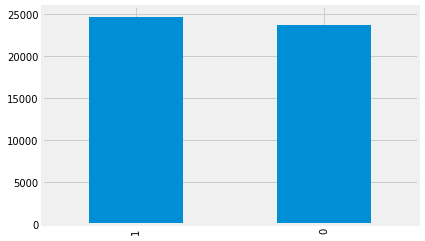

In [63]:
df.target.value_counts().plot(kind='bar')
plt.show()

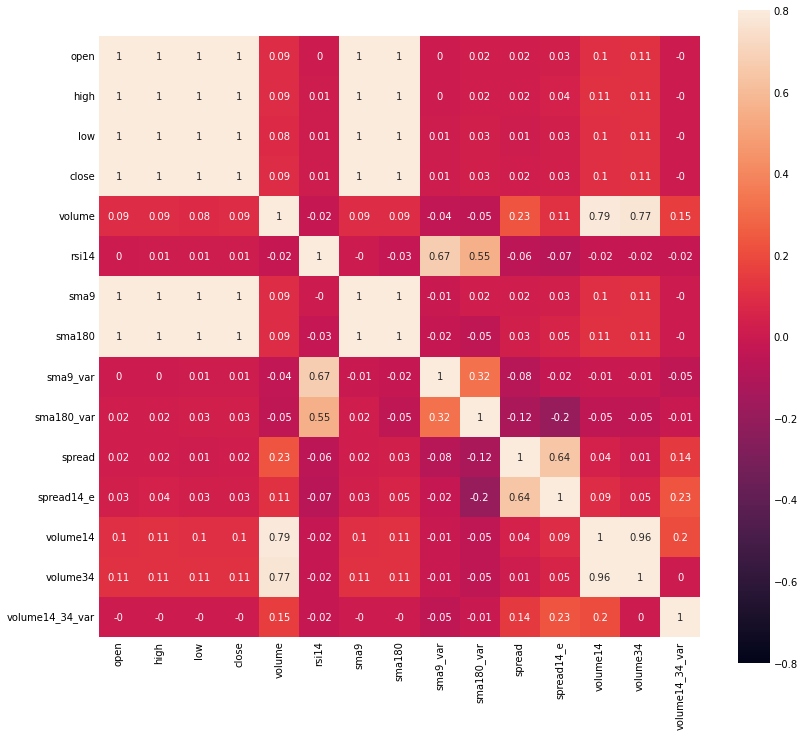

In [65]:
df_corr = df.drop(columns=['target']).corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(df_corr, vmin=-.8, vmax=.8, square=1 , annot=True)

In [66]:

train, test = train_test_split(df, test_size=0.2, random_state=42)

# Separate the label
y = train['target'].copy()
X = train.drop(columns=['target'])
y_test = test['target'].copy()
X_test = test.drop(columns=['target'])

In [67]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

float_cols = df.select_dtypes(include='float64').columns
tf = ColumnTransformer(
    [('RobustScaler', RobustScaler(), float_cols)],
    remainder='passthrough',
)
tf.fit(X)
X = tf.transform(X)
X_test = tf.transform(X_test)

In [82]:
start = time.time() 
parametres = {'n_estimators' : [10,50,100,300,500], #nombre d'arbres de décision
                  'min_samples_leaf' : [1,3,5,10], #nombre de feuilles minimales dans un noeud
                  'max_features': ['auto', 'sqrt'] #nombre de features observées pour chaque arbre
                 }

rfc_model = GridSearchCV(RandomForestClassifier(), param_grid=parametres , cv=5)
rfc_model.fit(X,y)
end = time.time()
print("execution time :", end -start)
print(rfc_model.best_params_)

execution time : 9234.878555297852
{'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}


In [68]:

rfc = RandomForestClassifier(max_features='sqrt', min_samples_leaf=10, n_estimators=500)
rfc.fit(X, y)



RandomForestClassifier(max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500)

In [132]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

# Faire des prédictions sur l'ensemble de test
y_pred = rfc.predict(X_test)

# Calculer le score ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Calculer la précision
precision = precision_score(y_test, y_pred)

# Calculer le rappel
recall = recall_score(y_test, y_pred)

# Calculer l'accuracy : 
accuracy = accuracy_score(y_test, y_pred)
# Afficher les scores
print("Accuracy score : {:.2f}".format(accuracy))
print("ROC AUC score : {:.2f}".format(roc_auc))
print("Precision score : {:.2f}".format(precision))
print("Recall score : {:.2f}".format(recall))


Accuracy score : 0.54
ROC AUC score : 0.54
Precision score : 0.54
Recall score : 0.58


In [137]:
current_data = df.drop(columns='target')
current_data = [current_data.iloc[-1]]
display(current_data)
prediction = rfc.predict(current_data)[0]
prediction

[open               22504.100000
 high               22512.700000
 low                22358.000000
 close              22385.200000
 volume              8636.580000
 rsi14                 45.326296
 sma9               22457.288889
 sma180             22912.372222
 sma9_var              -0.003210
 sma180_var            -0.023008
 spread                 0.005283
 spread14_e             0.001951
 volume14            8598.910000
 volume34            7255.017353
 volume14_34_var        0.185236
 Name: 2023-03-06 19:59:59.999000, dtype: float64]

In [97]:
prediction

0

###### Les variables qui ont contribuées plus au modèle (Features Importance):

In [135]:
importances = rfc.feature_importances_
features = train.drop(columns='target').columns
feat_importances = pd.DataFrame({'feature': features, 'importance': importances})


feat_importances = pd.DataFrame(feat_importances.sort_values('importance', ascending=False).reset_index(drop=True))


display(feat_importances)

,feature,importance
0,sma9_var,0.100639
1,rsi14,0.081477
2,spread,0.079327
3,volume14_34_var,0.077767
4,sma180_var,0.074897
5,volume,0.074075
6,spread14_e,0.073249
7,volume34,0.067556
8,volume14,0.067316
9,sma180,0.054888


###### Enregistrement du modèle : 

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=feat_importances.importance, y = feat_importances.feature)
plt.show()

In [ ]:
pickle.dump(rfc,open('model_opt_rfc.pkl','wb'))

## Sans indicateur : 

In [111]:
data = pd.read_csv('data.csv')
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data = data.set_index('close_time')
data.sort_index(inplace = True)
data.columns

Index(['id_symint', 'open_time', 'open_price', 'high_price', 'low_price',
       'close_price', 'volume', 'quote_asset_volume', 'number_of_trades',
       'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],
      dtype='object')

In [113]:
data.drop(columns=['high_price', 'low_price', 'quote_asset_volume',
                 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'], 
        inplace=True)

In [115]:
# Création de la variable cible
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Suppression de la dernière ligne pour éviter les valeurs nulles
df.drop(df.tail(1).index, inplace=True)

# Définition des features et de la variable cible
X = df[['open', 'close', 'volume']]
y = df['target']

# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [116]:
# Entraînement du modèle RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = rfc.predict(X_test)

In [133]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
print('Recall: {:.2f}'.format(recall))
print('ROC AUC: {:.2f}'.format(roc_auc))

Accuracy: 0.54
Recall: 0.58
ROC AUC: 0.54


In [140]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [141]:
import pandas_datareader.data as web

In [142]:
 https://stackoverflow.com/questions/65237843/predicting-stock-price-x-days-into-the-future-using-python-machine-learning

TypeError: string indices must be integers

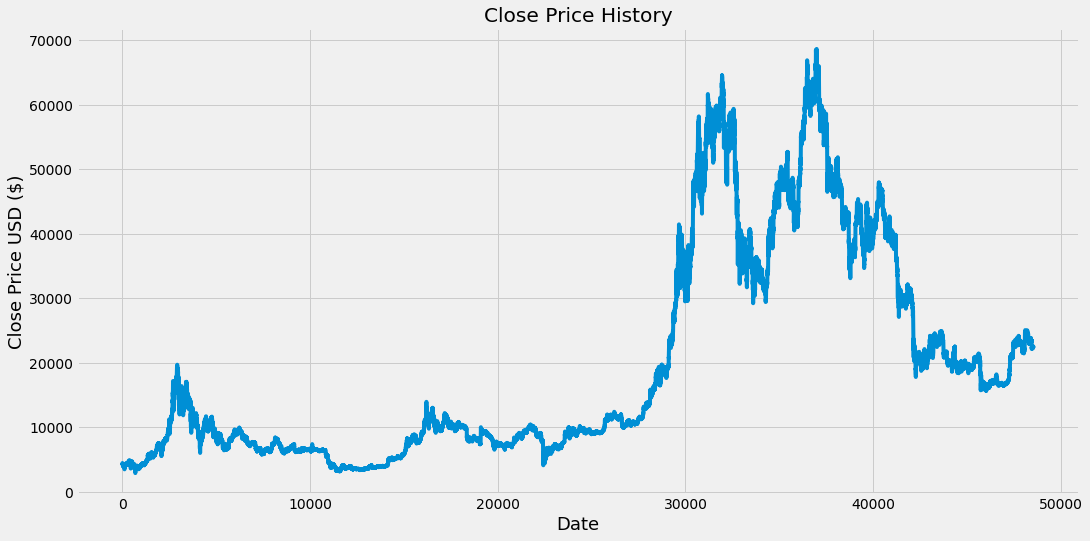

In [5]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#Get the stock quote
df = pd.read_csv('data.csv')

df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
#data = data.set_index('close_time')
df= df.rename(columns={'open_price':'open',
                          'high_price':'high',
                          'low_price':'low',
                           'close_price':'close',
                           'volume':'volume'
                          })


#Show the data
df
#Get the number of rows and columns in the data set
df.shape

#Visualize the closing price history
#We create a plot with name 'Close Price History'
plt.figure(figsize=(16,8))
plt.title('Close Price History')
#We give the plot the data (the closing price of our stock)

plt.plot(df['close'])
#We label the axis
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
#We show the plot
plt.show()


C:\Users\noumi\AppData\Local\Temp/ipykernel_19616/4010816640.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_24_hours['time'] = last_24_hours['close_time'].dt.strftime('%H:%M')


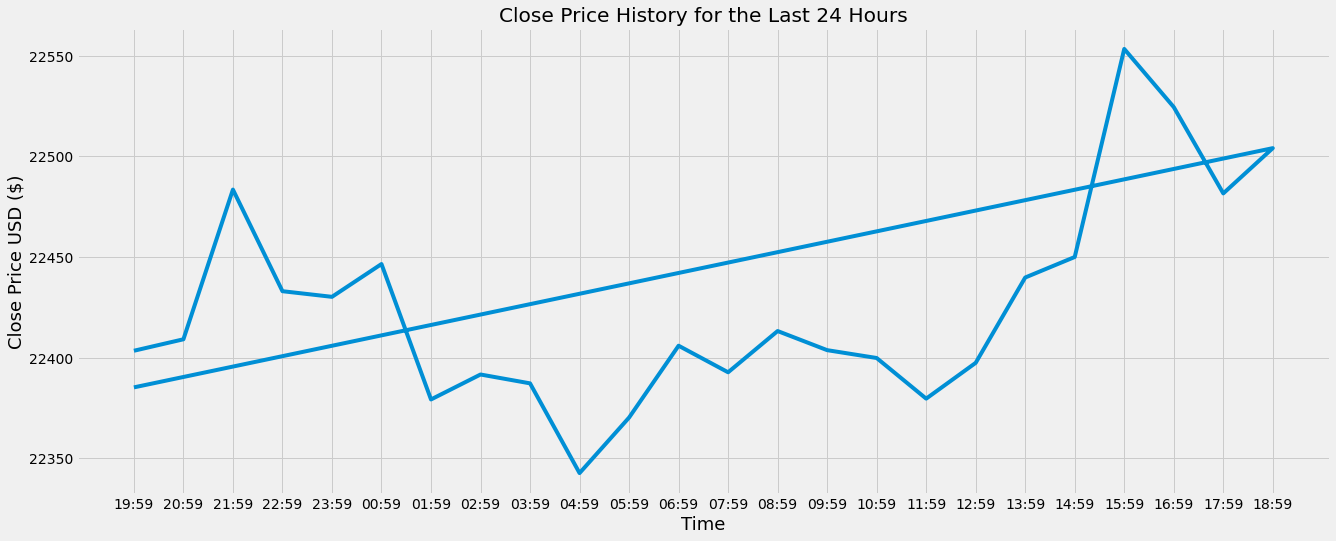

In [26]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Get the stock quote
df = pd.read_csv('data.csv')

df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df = df.rename(columns={
    'open_price': 'open',
    'high_price': 'high',
    'low_price': 'low',
    'close_price': 'close',
    'volume': 'volume'
})

# Sort the data by close_time in ascending order
df = df.sort_values('close_time')

# Filter data for the last 24 hours
last_24_hours = df[df['close_time'] >= df['close_time'].max() - pd.Timedelta(hours=24)]

# Extract hour and minute from the close_time column
last_24_hours['time'] = last_24_hours['close_time'].dt.strftime('%H:%M')

# Visualize the closing price history for the last 24 hours
plt.figure(figsize=(20, 8))
plt.title('Close Price History for the Last 24 Hours')
plt.plot(last_24_hours['time'], last_24_hours['close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()



C:\Users\noumi\AppData\Local\Temp/ipykernel_19616/29959884.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_24_hours['time'] = last_24_hours['close_time'].dt.strftime('%H:%M')


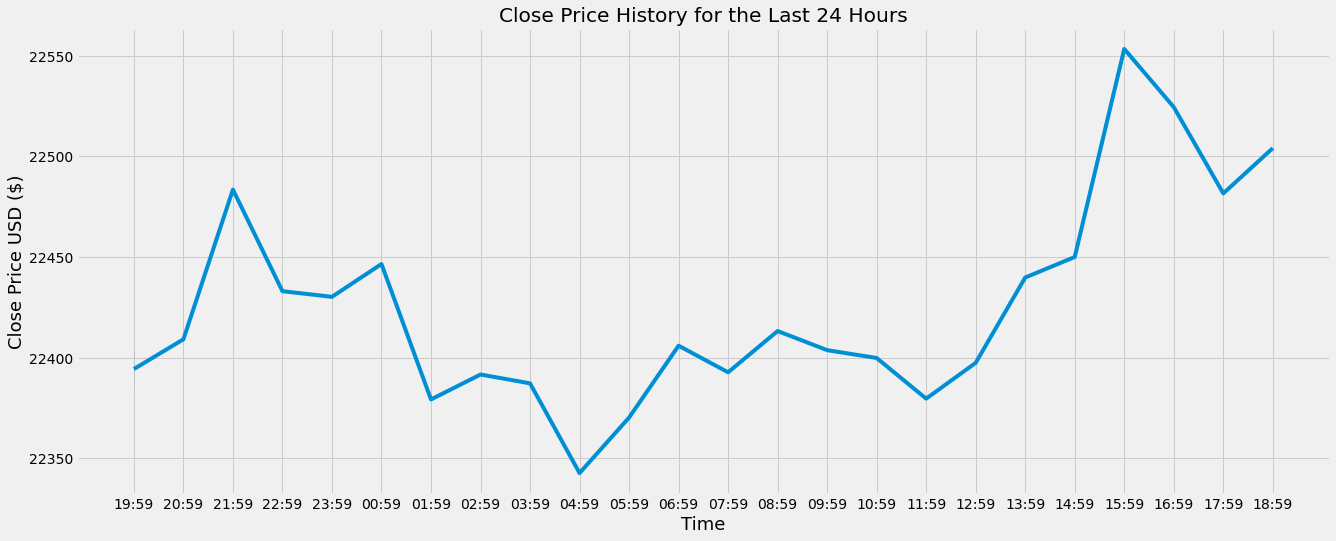

In [35]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Get the stock quote
df = pd.read_csv('data.csv')

df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
df = df.rename(columns={
    'open_price': 'open',
    'high_price': 'high',
    'low_price': 'low',
    'close_price': 'close',
    'volume': 'volume'
})

# Filter data for the last 24 hours
last_24_hours = df[df['close_time'] >= df['close_time'].max() - pd.Timedelta(hours=24)]

# Extract hour and minute from the close_time column
last_24_hours['time'] = last_24_hours['close_time'].dt.strftime('%H:%M')
last_24_hours= last_24_hours[['time', 'close']]

# Visualize the closing price history for the last 24 hours
plt.figure(figsize=(20, 8))
plt.title('Close Price History for the Last 24 Hours')
sns.lineplot(x= last_24_hours['time'], y = last_24_hours['close'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


In [37]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])

#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * 0.8 )


#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

#Create the training data set 
#Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
#We create a loop
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #Will conaint 60 values (0-59)
    y_train.append(train_data[i, 0]) #Will contain the 61th value (60)
    if i <= 60:
        print(x_train)
        print(y_train)
        print()


#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


[array([0.02114945, 0.02124821, 0.02138563, 0.0217758 , 0.02193862,
       0.02320638, 0.02344985, 0.02295225, 0.0227042 , 0.02343463,
       0.0236145 , 0.02181156, 0.02183956, 0.02085135, 0.02036028,
       0.02139902, 0.02172634, 0.02152563, 0.02157508, 0.02078804,
       0.02081011, 0.02015668, 0.02052189, 0.02089928, 0.02083126,
       0.02122143, 0.02070252, 0.02101889, 0.02075228, 0.02107824,
       0.02187197, 0.02162849, 0.02149763, 0.02090993, 0.02039726,
       0.02005472, 0.02025939, 0.01939216, 0.01823656, 0.01852371,
       0.01677113, 0.01607996, 0.01818086, 0.01809899, 0.01893777,
       0.01871012, 0.01882973, 0.01855825, 0.01748863, 0.01762163,
       0.01625009, 0.01695922, 0.01643468, 0.01748772, 0.01645872,
       0.01580468, 0.01789554, 0.01705615, 0.01709526, 0.01602457])]
[0.016449896294132058]



In [38]:

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


38770/38770 [==============================] - 720s 19ms/step - loss: 1.9436e-04


304/304 [==============================] - 3s 11ms/step


C:\Users\noumi\AppData\Local\Temp/ipykernel_19616/1657611918.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


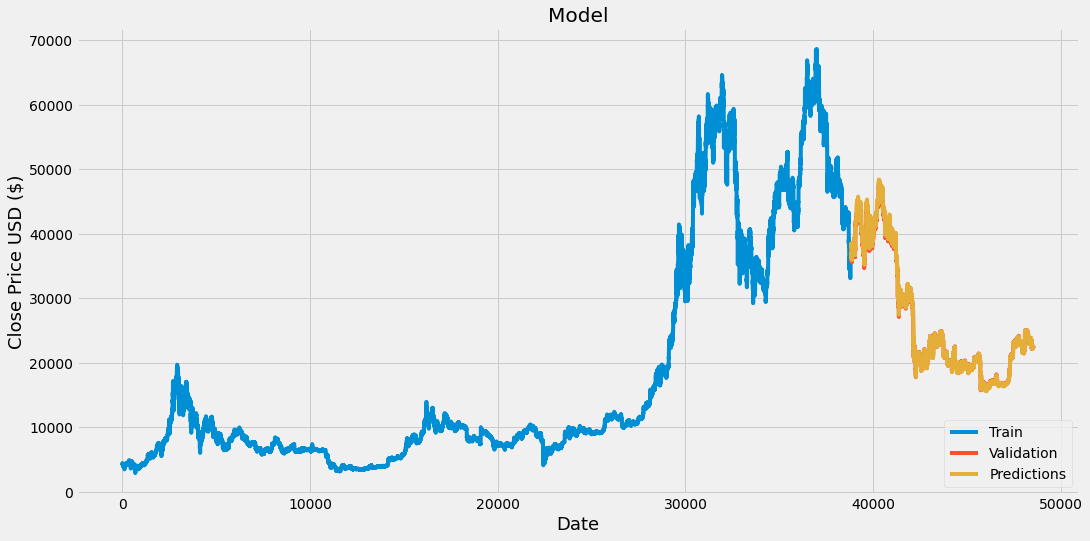

In [40]:

#Create the testing data set
#Create a new array containing scaled values from index 1738 to 2247
test_data = scaled_data[training_data_len - 60:]
#Create the data set x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#Convert the data to a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Get the model's predicted price values for the x_test data set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions

#Evaluate model (get the root mean quared error (RMSE))
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()
